# AAE 450 Battery Mass Simulation
## Noah Stockwell

### Last reviewed 3/31/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
sns.set_theme()

## Define a simple object to store all models:

In [3]:
class Model:
    def __init__(self, fnctn, confidence):
        self.model = fnctn
        self.confidence = confidence
        
model_list = []

## Model 1: SAFT 10S8P VES16

In [4]:
# https://www.nasa.gov/sites/default/files/atoms/files/ves16_cell_batt_design_yborthomieu.pdf
# Slide 24

def saft_10s8p(num_samples):
    energy = sts.norm.rvs(loc=1300 / 1e3, scale=75 / 1e3, size=num_samples)
    mass = sts.norm.rvs(loc=11.5, scale=.5, size=num_samples)
    
    return np.vstack([energy, mass])

model_list.append(Model(saft_10s8p, 4))    

## Model 2: SAFT cells + 5% structure

In [5]:
# https://www.nasa.gov/sites/default/files/atoms/files/ves16_cell_batt_design_yborthomieu.pdf
# Slide 7

def saft_cells(num_samples):
    mass = sts.uniform.rvs(loc=2, scale=30, size=num_samples)
    energy = sts.norm.rvs(loc=169, scale=4, size=num_samples) / 1e3 *  mass
    
    mass = 1.05 * mass
    
    return np.vstack([energy, mass])

model_list.append(Model(saft_cells, 3))

## Model 3: SAFT & Orbital

In [6]:
# https://eepower.com/news/saft-li-ion-batteries-selected-for-geo-telecom-satellites/#

def saft_orbital(num_samples):
    mass = sts.uniform.rvs(loc=2, scale=30, size=num_samples)
    energy = sts.norm.rvs(loc=120, scale=10, size=num_samples) / 1e3 *  mass
    
    return np.vstack([energy, mass])

model_list.append(Model(saft_orbital, 1))

## Run the Monte Carlo Simulation:

In [7]:
n = 2**8

mod_arr = [x.model(int(n * x.confidence)) for x in model_list]
res = np.hstack(mod_arr)

stats_table = pd.DataFrame(data=res.T, columns=['Energy', 'Mass'])

## Produce a plot with resulting curves:

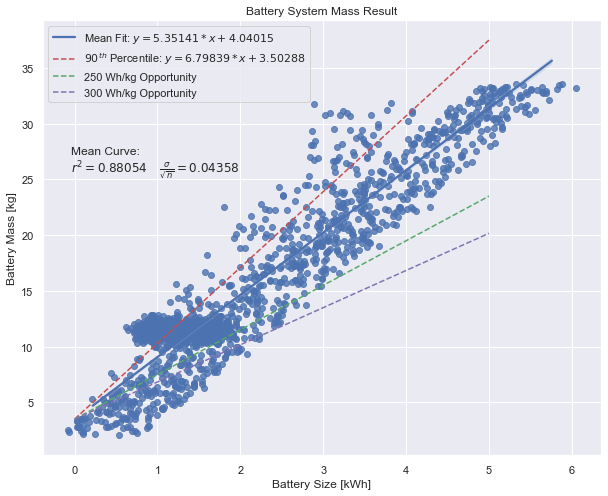

In [8]:
x_name = 'Energy'
y_name = 'Mass'


x=stats_table[x_name]
y=stats_table[y_name]

# Model Fit
x_model = np.linspace(0, 5)
a = .9
mod = smf.quantreg(y_name + ' ~ ' + x_name, stats_table)
fit = mod.fit(q=a)
top_bs = fit.params['Intercept']
top_ms = fit.params[x_name]
y_model = top_bs + x_model * top_ms

# Best case scenarios
y250 = x_model / (250 / 1e3)
y300 = x_model / (300 / 1e3)


# Begin Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.regplot(x=x, y=y, ci=99, x_jitter=.5)
plt.plot(x_model, y_model, 'r--')

plt.plot(x_model, 3.5 + y250, ls='--', c=sns.color_palette()[2])
plt.plot(x_model, 3.5 + y300, ls='--', c=sns.color_palette()[4])

# Helper Functions
ax.set_xlabel('Battery Size [kWh]')
ax.set_ylabel('Battery Mass [kg]')
ax.set_title('Battery System Mass Result')
lr = sts.linregress(ax.collections[0].get_offsets().data)
ytxt = np.ptp(ax.get_ylim()) * .65 + ax.get_ylim()[0]
x_txt = np.ptp(ax.get_xlim()) * .05 + ax.get_xlim()[0]
plt.text(x_txt, ytxt, f"Mean Curve:\n$r^2={lr.rvalue**2:.5f}$    " + r"$\frac{\sigma}{\sqrt{n}}=$" + f"${lr.stderr:.5f}$")
plt.legend([f'Mean Fit: $y={lr.slope:.5f}*x+{lr.intercept:.5f}$', 
            f'${100 * a:.0f}^{{th}}$ Percentile: $y={top_ms:.5f}*x+{top_bs:.5f}$',
           '250 Wh/kg Opportunity', '300 Wh/kg Opportunity'])

fig.savefig('battery_mass.png', dpi=300)